# IPL Match Winner Prediction
Install pandas and numpy

In [1]:
import pandas as pd

Read data from CSV datasets

In [2]:
match = pd.read_csv('data/matches.csv')
delivery = pd.read_csv('data/deliveries.csv')

In [3]:
delivery.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


- find the total runs of each innings
- group by match_id and inning and sum the total runs & store in 'total_runs' column

In [4]:
delivery.groupby(['match_id', 'inning']).sum()['total_runs']

match_id  inning
335982    1         222
          2          82
335983    1         240
          2         207
335984    1         129
                   ... 
1426310   2         174
1426311   1         175
          2         139
1426312   1         113
          2         114
Name: total_runs, Length: 2217, dtype: int64

- reset the index of the dataframe and store in 'total_score_df'

In [5]:
total_score_df = delivery.groupby(['match_id', 'inning']).sum()['total_runs'].reset_index()

- Filter the innings 1 (first inning)

In [6]:
total_score_df = total_score_df[total_score_df['inning'] ==1]

In [7]:
total_score_df

,match_id,inning,total_runs
0,335982,1,222
2,335983,1,240
4,335984,1,129
6,335985,1,165
8,335986,1,110
...,...,...,...
2207,1426307,1,214
2209,1426309,1,159
2211,1426310,1,172
2213,1426311,1,175


- Till now, we got the first inning total runs for each match

- Now, merge the match and total_score_df dataframes by match_id present in total_score_df & id present in match, store in match_df

In [8]:
match_df = match.merge(total_score_df[['match_id', 'total_runs']], left_on='id', right_on='match_id')

In [9]:
match_df['team1'].unique() # find all unique teams

array(['Royal Challengers Bangalore', 'Kings XI Punjab',
       'Delhi Daredevils', 'Mumbai Indians', 'Kolkata Knight Riders',
       'Rajasthan Royals', 'Deccan Chargers', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Gujarat Lions', 'Rising Pune Supergiants',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans',
       'Royal Challengers Bengaluru'], dtype=object)

In [10]:
# Current teams
teams = [
    'Chennai Super Kings',
    'Royal Challengers Bengaluru',
    'Delhi Capitals',
    'Kolkata Knight Riders',
    'Mumbai Indians',
    'Punjab Kings',
    'Rajasthan Royals',
    'Sunrisers Hyderabad',
    'Lucknow Super Giants', 
    'Gujarat Titans'
]

In [11]:
# Fix team names
match_df['team1'] = match_df['team1'].str.replace('Royal Challengers Bangalore', 'Royal Challengers Bengaluru')
match_df['team2'] = match_df['team2'].str.replace('Royal Challengers Bangalore', 'Royal Challengers Bengaluru')

match_df['team1'] = match_df['team1'].str.replace('Kings XI Punjab', 'Punjab Kings')
match_df['team2'] = match_df['team2'].str.replace('Kings XI Punjab', 'Punjab Kings')

match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils', 'Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils', 'Delhi Capitals')

match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')

In [12]:
match_df = match_df[match_df['team2'].isin(teams) & match_df['team1'].isin(teams)]

In [13]:
# match_df['method'].unique()
match_df.columns

Index(['id', 'season', 'city', 'date', 'match_type', 'player_of_match',
       'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner',
       'result', 'result_margin', 'target_runs', 'target_overs', 'super_over',
       'method', 'umpire1', 'umpire2', 'match_id', 'total_runs'],
      dtype='object')

In [14]:
# Remove D/L method (DLS Method)
match_df = match_df[match_df['method'] != 'D/L']

In [15]:
# Extract the required fields such as city, winner, total_runs
match_df = match_df[['match_id', 'city', 'winner', 'total_runs']]

In [16]:
match_df

,match_id,city,winner,total_runs
0,335982,Bangalore,Kolkata Knight Riders,222
1,335983,Chandigarh,Chennai Super Kings,240
2,335984,Delhi,Delhi Daredevils,129
3,335985,Mumbai,Royal Challengers Bangalore,165
4,335986,Kolkata,Kolkata Knight Riders,110
...,...,...,...,...
1090,1426307,Hyderabad,Sunrisers Hyderabad,214
1091,1426309,Ahmedabad,Kolkata Knight Riders,159
1092,1426310,Ahmedabad,Rajasthan Royals,172
1093,1426311,Chennai,Sunrisers Hyderabad,175


In [17]:
# Merge this match_df with delivery
delivery_df = match_df.merge(delivery, on="match_id")

In [18]:
# Filter for second innings, as we have to find while chasing the target
delivery_df = delivery_df[delivery_df['inning'] == 2]

In [19]:
# Calculate the current score after each delivery
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()


In [20]:
# Calculate runs left after each delivery
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score'] + 1   # 1 run extra needed for win

In [21]:
# Select only valid balls
delivery_df['extras_type'].unique()
# delivery_df['ball'].unique()

array([nan, 'wides', 'legbyes', 'byes', 'noballs', 'penalty'],
      dtype=object)

In [22]:
# Create column that indicates if ball is legal
delivery_df['is_legal'] = ~delivery_df['extras_type'].isin(['wides', 'legbyes', 'byes', 'noballs', 'penalty'])

In [23]:
delivery_df['is_legal'] = delivery_df['is_legal'].fillna(True)

In [24]:
delivery_df['legal_ball_number'] = delivery_df.groupby(['match_id', 'inning'])['is_legal'].cumsum()

In [25]:
# Calculate overs completed
delivery_df['overs_done'] = delivery_df['legal_ball_number'] / 6

In [26]:
# Calculate wickets left
delivery_df['wickets_left'] = 10 - delivery_df.groupby('match_id')['is_wicket'].cumsum()

In [27]:
# Calculate current run rate
# crr = (runs scored / overs played)
delivery_df['crr'] = delivery_df.apply(
    lambda x: x['current_score'] / x['overs_done'] if x['overs_done'] > 0 else 0,
    axis=1
)

In [28]:
# Calculate required run rate
# rrr = (runs needed / overs left)
delivery_df['overs_left'] = (120 - delivery_df['legal_ball_number']) / 6
delivery_df['rrr'] = delivery_df.apply(
    lambda x: x['runs_left'] / x['overs_left'] if x['overs_left'] > 0 else 0,
    axis=1
)

In [29]:
# Calculate result as boolean (win = 1, loss = 0)
# if batting team in 2nd inning is winner then result = 1 else result = 0
# for this we create a function & apply to each row
def result(row): 
    return 1 if row['batting_team'] == row['winner'] else 0

In [30]:
delivery_df['result'] = delivery_df.apply(result, axis=1)   # axis=1 for row wise

In [31]:
delivery_df['balls_left'] = 120 - delivery_df['legal_ball_number']
delivery_df['balls_left'] = delivery_df.apply(
    lambda x: 120 - x['legal_ball_number'] if x['inning'] == 2 else None,
    axis=1
)

In [32]:
# Extract required columns
final_df = delivery_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'total_runs_x', 'crr', 'rrr', 'result']]

In [33]:
# shuffle each delivery to avoid overfitting / bias
final_df = final_df.sample(final_df.shape[0])

In [34]:
# sample row
final_df.sample()

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,total_runs_x,crr,rrr,result
182311,Gujarat Titans,Punjab Kings,Mumbai,165,107,10,189,11.538462,9.252336,1


In [35]:
# removes all rows in final_df that contains at lease one NaN value
final_df.dropna(inplace=True)

In [36]:
# Filter out all rows where balls_left is not Zero
final_df = final_df[final_df['balls_left'] != 0]

- Till now, our dataset is clean and ready for model training

# Model Training

In [37]:
# Import train_test_split for splitting data
X = final_df.iloc[:,:-1] # all rows & all columns except result (last column)
y = final_df.iloc[:,-1] # all rows & last column only

from sklearn.model_selection import train_test_split        # This imports the function to split your data into training and test sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training data & 20% test data, random_state=1 for reproducibility

In [38]:
# X.info()

In [39]:
# Convert categorical data to numeric formats

from sklearn.compose import ColumnTransformer   # apply transformer to specific columns
from sklearn.preprocessing import OneHotEncoder # convert categorical to binary values

# Create the ColumnTransformer
trf = ColumnTransformer([
    ('trf', OneHotEncoder(sparse_output=False, drop='first'), ['batting_team', 'bowling_team', 'city']) 
    # sparse_output=False to return numpy array
    # drop='first' to avoid dummy variable trap
], remainder='passthrough') # remainder='passthrough' to keep the other columns as it is


In [42]:
# Logistic Regression & Random Forest model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.pipeline import Pipeline

In [64]:
# Create the pipeline

# Logistic Regression
pipe = Pipeline(steps=[
    ('step1', trf),
    ('step2', LogisticRegression(solver='liblinear'))
    # ('step2', RandomForestClassifier())
])

In [65]:
pipe.fit(X_train, y_train)

/home/manas/coding/python/jupyter/venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [71]:
# Find accuracy score of the model 
from sklearn.metrics import accuracy_score
y_pred = pipe.predict(X_test)
accuracy_score(y_test, y_pred)
# Logistic Regression = 0.8104476199488975
# Random Forest = 0.9984385350619854

# We will use logistic regression, coz we need only win/loss

0.8104476199488975

In [82]:
import numpy as np

In [104]:
def match_progression(x_df, match_id, pipe):
    # Filter the DataFrame for the given match_id
    match = x_df[x_df['match_id'] == match_id]

    # Only consider the last ball of each over (i.e., ball number 6)
    match = match[(match['ball'] == 6)]

    # Select relevant features and remove rows with missing values
    temp_df = match[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
                     'wickets_left', 'total_runs_x', 'crr', 'rrr']].dropna()

    # Remove rows where no balls are left (i.e., innings is over)
    temp_df = temp_df[temp_df['balls_left'] != 0]

    # Predict win and loss probabilities using the trained model pipeline
    result = pipe.predict_proba(temp_df)

    # Add predicted lose and win probabilities (in percentage) to temp_df
    temp_df['lose'] = np.round(result.T[0] * 100, 1)
    temp_df['win'] = np.round(result.T[1] * 100, 1)

    # Add an 'end_of_over' column to indicate over progression (1 to n)
    temp_df['end_of_over'] = range(1, temp_df.shape[0] + 1)

    # Extract target runs from the total_runs_x column (assumes constant for match)
    target = temp_df['total_runs_x'].values[0]

    # Calculate runs scored in each over
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]  # Copy of runs_left after each over
    runs.insert(0, target)  # Insert total target at the start
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)  # Difference gives runs in that over

    # Calculate wickets lost in each over
    wickets = list(temp_df['wickets_left'].values)
    new_wickets = wickets[:]  # Copy of wickets_left
    new_wickets.insert(0, 10)  # Start with 10 wickets
    wickets.append(0)          # Add dummy value to match lengths
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]  # Difference gives wickets lost in that over

    # Print the target for reference
    print("Target-", target)

    # Keep only relevant columns for plotting or further analysis
    temp_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']]

    return temp_df, target


In [105]:
temp_df,target = match_progression(delivery_df, 1181768, pipe)

Target- 149


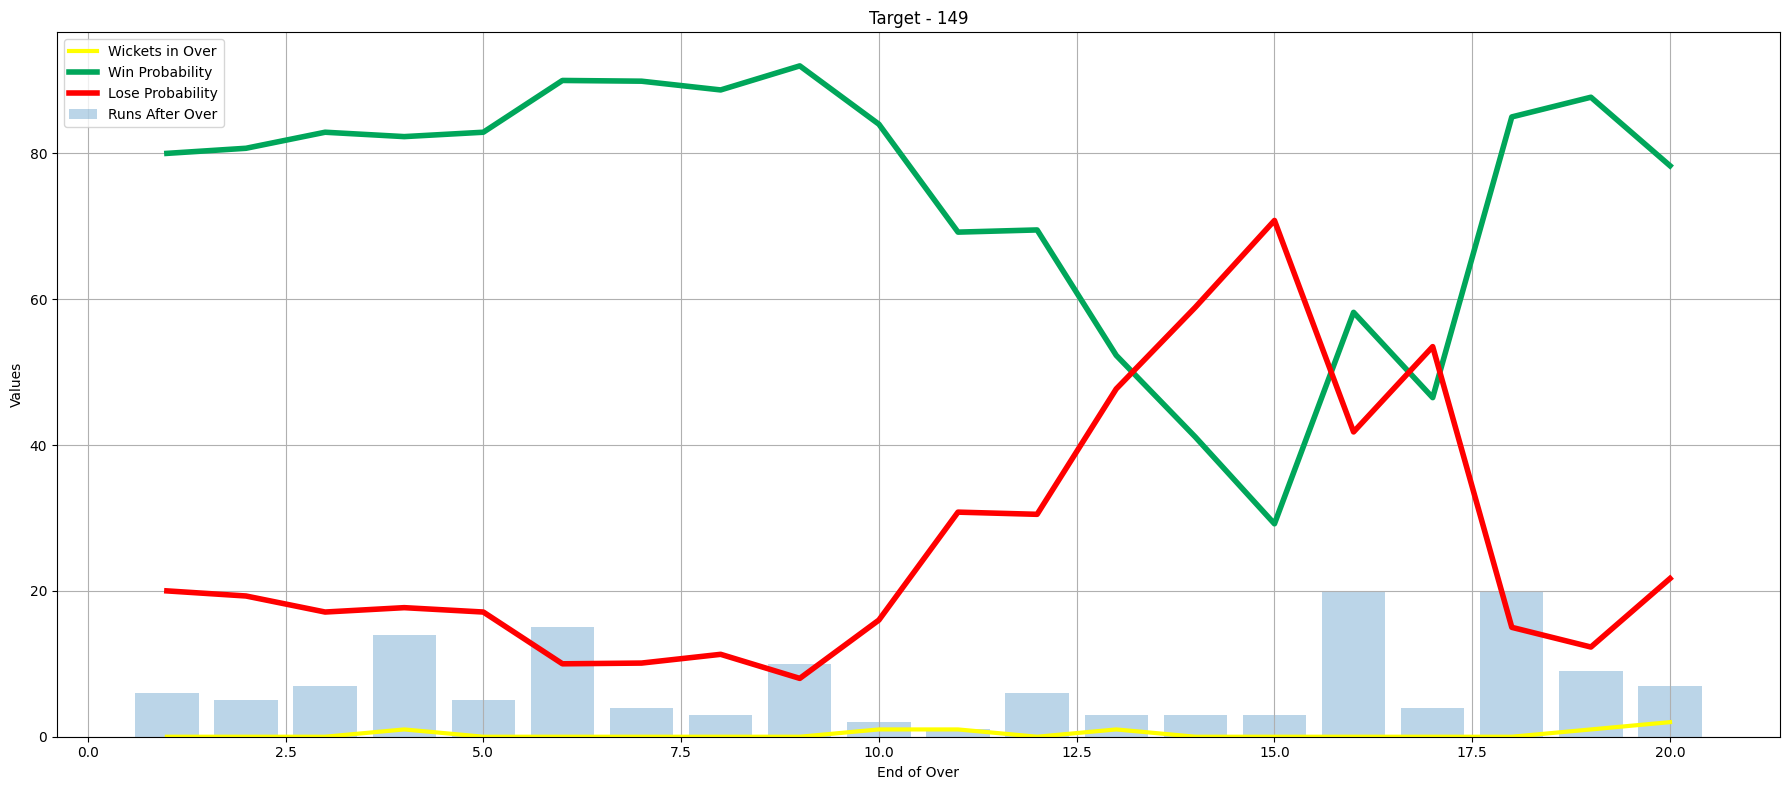

In [106]:
# plot the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

# Line plot: Wickets lost per over
plt.plot(temp_df['end_of_over'], temp_df['wickets_in_over'], color='yellow', linewidth=3, label='Wickets in Over')

# Line plot: Win probability
plt.plot(temp_df['end_of_over'], temp_df['win'], color='#00a65a', linewidth=4, label='Win Probability')

# Line plot: Lose probability
plt.plot(temp_df['end_of_over'], temp_df['lose'], color='red', linewidth=4, label='Lose Probability')

# Bar chart: Runs scored after each over
plt.bar(temp_df['end_of_over'], temp_df['runs_after_over'], alpha=0.3, label='Runs After Over')

# Title and legend
plt.title('Target - ' + str(target))
plt.xlabel('End of Over')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- Fetch the fields to display

In [107]:
teams

['Chennai Super Kings',
 'Royal Challengers Bengaluru',
 'Delhi Capitals',
 'Kolkata Knight Riders',
 'Mumbai Indians',
 'Punjab Kings',
 'Rajasthan Royals',
 'Sunrisers Hyderabad',
 'Lucknow Super Giants',
 'Gujarat Titans']

In [108]:
city = delivery_df['city'].unique()
city

array(['Bangalore', 'Chandigarh', 'Delhi', 'Mumbai', 'Kolkata', 'Jaipur',
       'Hyderabad', 'Chennai', 'Cape Town', 'Port Elizabeth', 'Durban',
       'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi', nan,
       'Bengaluru', 'Indore', 'Dubai', 'Sharjah', 'Navi Mumbai',
       'Lucknow', 'Guwahati', 'Mohali'], dtype=object)

In [109]:
import pickle  # Import the pickle module to save/load Python objects

# Save the trained model pipeline object 'pipe' to a file named 'pipe.pkl' in binary write mode
pickle.dump(pipe, open('pipe.pkl', 'wb'))